# Trying "acoustic" features
[avloss](https://www.kaggle.com/avloss/audio-analysis-with-animation) and [eigrad](https://www.kaggle.com/eigrad/wip-some-audio-digging) has nicely shown us that our "acoustic_data" is literally acoustic audio data.  
So, I feel like trying methods from Audio/Music Information Retrieval (AIR/MIR).  
In this notebook, I try a famous and successful audio feature called [Mel-frequency cepstral coefficients (MFCC)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

# train.csv is huge, so I implement csv_fragments() function
# which yields DataFrame of the specified length while scaning a csv file from start to end.

import builtins

random_seed = 4126

cast = {
    'acoustic_data': 'int',
    'time_to_failure': 'float'
}

def df_fragments(path, length, skip=1):
    with open(path, 'r') as f:
        m = {}
        cols = []
        count = 0
        index = 0
        for line in f:
            if len(cols) == 0:
                for col in line.strip("\n\r ").split(','):
                    cols.append(col)
                continue
            if count == 0:
                for col in cols:
                    m[col] = []
            if index % skip == 0:
                for j, cell in enumerate(line.strip("\n\r ").split(',')):
                    col = cols[j]
                    m[col].append(getattr(builtins, cast[col])(cell))
            count += 1
            if count == length:
                if index % skip == 0:
                    yield pd.DataFrame(m)
                index += 1
                count = 0

def count_rows(path):
    with open(path, 'r') as f:
        i = -1
        for _ in f:
            i += 1
        return i

[**LibROSA**](https://librosa.github.io/librosa/index.html) is an easy-to-use library to calculate audio features.

In [2]:
import librosa, librosa.display

Let's see MFCC of train data (first 150,000 records)

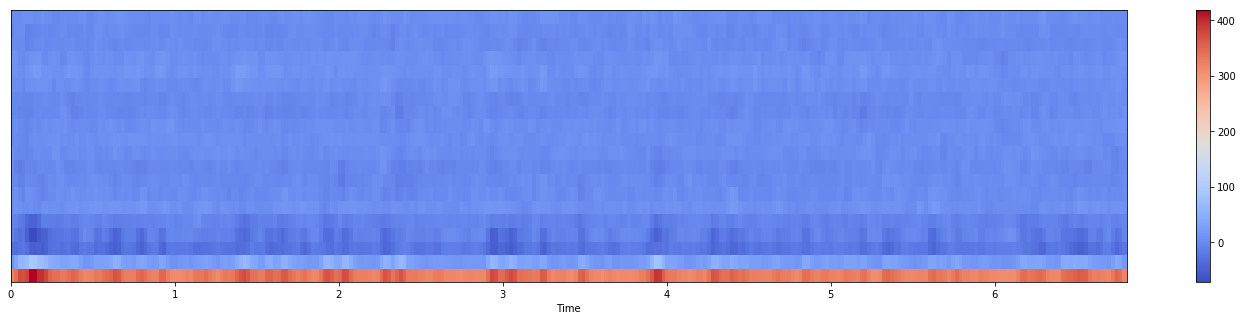

In [3]:
for df in df_fragments('./input/train.csv', 150000):
    mfcc = librosa.feature.mfcc(df['acoustic_data'].values.astype('float32'))
    plt.figure(figsize=(25, 5))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    break

The shape of MFCC is (\[No. of features (20 by default)\], \[time\]).  
I tentatively create train data by calculating mean values along time axis for each 150000 train records (same size as test data fragments).

In [4]:
print('counting total...')
total = 629145480
print('total: {}'.format(total))

counting total...
total: 629145480


In [5]:
print('generating train data...')
fragment_size = 150000
skip = 1
# you can reduce train data to process for some quick experiments
# skip = 10

mfcc_ttf_map = {}
for df in tqdm(df_fragments('./input/train.csv', length=fragment_size, skip=skip), total=(total//fragment_size)//skip):
    mfcc = librosa.feature.mfcc(df['acoustic_data'].values.astype('float32'))
    mfcc_mean = mfcc.mean(axis=1)
    for i, each_mfcc_mean in enumerate(mfcc_mean):
        key = 'mfcc_{}'.format(i)
        if key not in mfcc_ttf_map:
            mfcc_ttf_map[key] = []
        mfcc_ttf_map[key].append(each_mfcc_mean)
    key = 'time_to_failure'
    if key not in mfcc_ttf_map:
        mfcc_ttf_map[key] = []
    mfcc_ttf_map[key].append(df.iloc[-1][key])

mfcc_ttf_df = pd.DataFrame(mfcc_ttf_map)
fname = 'mfcc_train.csv'
mfcc_ttf_df.to_csv(fname, index=False)
print('saved {}.'.format(fname))
        

generating train data...


KeyboardInterrupt: 

Let's visualize train data.

In [ ]:
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

mfcc_ttf_df['time_to_failure'].plot(ax=ax1, y='time_to_failure', legend=True, color='black')
ax1.legend(loc='upper left')
mfcc_ttf_df.drop(['time_to_failure'], axis=1).plot(ax=ax2, legend=True)
plt.show()

Some of mean MFCC feature values seem to have linear relationship with time_to_failure.  
Let's try linear regression (cross validation fold=10).

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def report_cv(model):
    X = mfcc_ttf_df.drop(['time_to_failure'], axis=1).values
    y = mfcc_ttf_df['time_to_failure'].values
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=10)
    print('Cross Validation scores: {}'.format(abs(scores)))
    print('Average score: {}'.format(abs(scores.mean())))

report_cv(LinearRegression())

Also try XGBoost

In [ ]:
from xgboost import XGBRegressor

report_cv(XGBRegressor(random_state=random_seed))

Following is a graph with cross-validation fold boundary (red vertical line).  
It seems both models work poorly when time_to_failure of test data is abnormally large (5th or 9th fold) or abnormally small (4th fold).  


In [ ]:
from matplotlib import patches 

fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

mfcc_ttf_df['time_to_failure'].plot(ax=ax1, y='time_to_failure', legend=True, color='black')
ax1.legend(loc='upper left')
mfcc_ttf_df.drop(['time_to_failure'], axis=1).plot(ax=ax2, legend=True)

fold_len = len(mfcc_ttf_df)//10
for i in range(1, 10):
    plt.axvline(x=fold_len * i,color='red')

plt.show()

Following is just my imagination...  
We can see small spikes between the times of failure, and after such spikes mfcc values go down in some degree. Aren't they small failures which were not recorded as actual failures? Such small failures seem to postpone following actual failures (corresponding to foreshock in real world?). If we could detect such small failures, we may be able to improve our score, but it seems impossible for me to detect small failures from fragmented and shuffled test data...

In [ ]:
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

mfcc_ttf_df['time_to_failure'].plot(ax=ax1, y='time_to_failure', legend=True, color='black')
ax1.legend(loc='upper left')
mfcc_ttf_df.drop(['time_to_failure'], axis=1).plot(ax=ax2, legend=True)

ax2.add_patch(patches.Rectangle((170,320),80, 80,linewidth=3,edgecolor='r',facecolor='none'))
ax2.add_patch(patches.Rectangle((490,320),80,80,linewidth=3,edgecolor='r',facecolor='none'))
ax2.add_patch(patches.Rectangle((1780,320),80,80,linewidth=3,edgecolor='r',facecolor='none'))
ax2.text(1780, 280, 'small failure?', fontsize=15)

plt.show()

Anyway, let's create files for submission using all the train data.

In [ ]:
import re
import os

print('generating test features...')
test_dir = './input/test'
test_map = {}
for fname in tqdm(os.listdir(test_dir)):
    path = test_dir + '/' + fname
    df = pd.read_csv(path,delimiter=',', header=None,
                                   error_bad_lines=False)
    mfcc = librosa.feature.mfcc(df['acoustic_data'].values.astype('float32'))
    mfcc_mean = mfcc.mean(axis=1)
    for i, each_mfcc_mean in enumerate(mfcc_mean):
        key = 'mfcc_{}'.format(i)
        if key not in test_map:
            test_map[key] = []
        test_map[key].append(each_mfcc_mean)
    key = 'seg_id'
    if key not in test_map:
        test_map[key] = []
    test_map[key].append(re.sub('.csv$', '', fname))
test_df = pd.DataFrame(test_map)
test_csv = 'mfcc_test.csv'
test_df.to_csv(test_csv, index=False)
print('saved {}'.format(test_csv))


def submit(model, file_path):
    X = mfcc_ttf_df.drop(['time_to_failure'], axis=1).values
    y = mfcc_ttf_df['time_to_failure'].values
    model.fit(X, y)
    
    X_submit = test_df.drop(['seg_id'], axis=1).values
    y_submit = model.predict(X_submit)
    submit_df = pd.DataFrame({
        'seg_id': test_df['seg_id'].values,
        'time_to_failure': y_submit
    })
    submit_df.to_csv(file_path, index=False)
    print('saved {}'.format(file_path))
    

In [ ]:
submit(LinearRegression(), 'submit_linear.csv')
submit(XGBRegressor(random_state=random_seed), 'submit_xgb.csv')

I hope specialists of Audio/Music Information Retrieval go into detail of acoustic features. Thanks!